In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [38]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta

# Reflect Tables into SQLAlchemy ORM

In [57]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,desc, inspect,func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
# reflect the tables


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [74]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [20]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [71]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [59]:
# Find the most recent date in the data set.
sel = [measurement.date]
ordered_dates = session.query(*sel).\
    order_by(desc(measurement.date)).all()
last_date = ordered_dates[0][0]
last_date = datetime.strptime(last_date,'%Y-%m-%d').date()
last_date

datetime.date(2017, 8, 23)

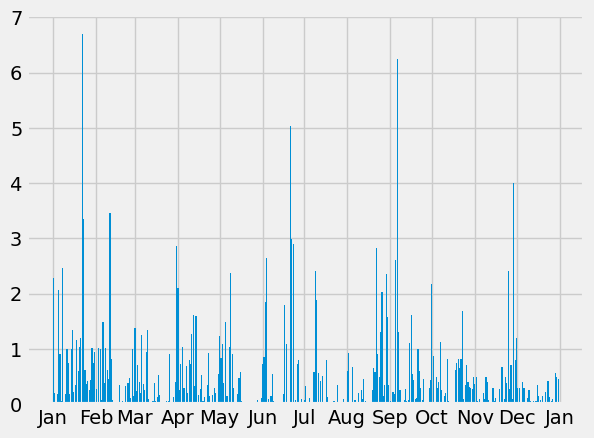

In [70]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
new_date = last_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date,measurement.prcp]
last_12_months = session.query(*sel).\
    filter(measurement.date > new_date).\
    order_by(measurement.date).all()
last_12_months

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(last_12_months,columns=['Date','Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
ax.bar(df["Date"],df["Precipitation"])
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.show()

In [65]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [89]:
# Design a query to calculate the total number of stations in the dataset
sel = [func.count(station.station)]
total_stations = session.query(*sel).\
    order_by(station.station).all()
total_stations

[(9,)]

In [95]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [station.station,func.count(measurement.prcp)]
stations = session.query(*sel).\
    filter(station.station == measurement.station).\
    group_by(station.station).\
    order_by(desc(func.count(measurement.prcp))).all()
stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [96]:
most_active = stations[0][0]

In [97]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
summary = session.query(*sel).\
    filter(measurement.station == most_active).\
    order_by(measurement.station).all()
summary

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

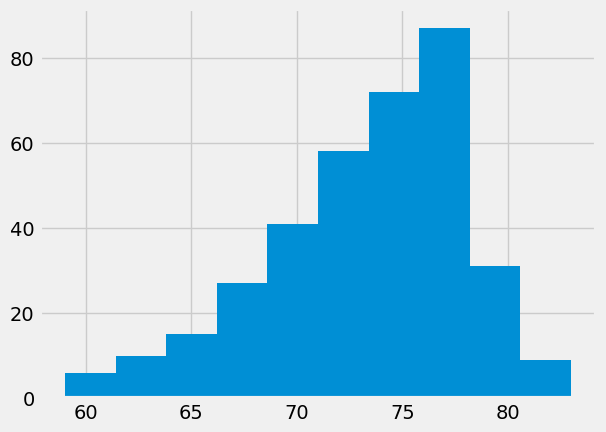

In [104]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the most recent date in the data set for this station.
sel = [measurement.date]
ordered_dates = session.query(*sel).\
    filter(measurement.station == most_active).\
    order_by(desc(measurement.date)).all()
last_date = ordered_dates[0][0]
last_date = datetime.strptime(last_date,'%Y-%m-%d').date()
last_date

# Calculate the date one year from the last date in data set.
new_date = last_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.tobs]
last_12_months = session.query(*sel).\
    filter(measurement.date > new_date, measurement.station == most_active).\
    order_by(measurement.date).all()
last_12_months

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(last_12_months,columns=['tobs'])

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
ax.hist(df["tobs"])
plt.show()

# Close Session

In [16]:
# Close Session
session.close()